# 微调

![img](https://zh-v2.d2l.ai/_images/finetune.svg)

预训练的数据在第 $1$ 层到第 $L-1$ 层的 $weight$ 可以直接 $copy$ 到模型中去, 低层主要是识别一些小的特征, 高层主要是针对数据集做的一些识别, 所以低层的 $weight$ 基本是不需要调的, 只需要微调就可以了, 对全连接层进行从头训练就可以了

In [1]:
import torch
import torchvision
from torch import nn
import d2l.torch as d2l
import os

In [2]:
# d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip', 'fba480ffa8aa7e0febbb511d181409f899b9baa5')
# data_dir = d2l.download_extract('hotdog')
data_dir = '..\\data\\hotdog'

`os.path.join` 可以理解为是拼接地址字符串

$ImageFolder$ 函数可以处理 : 
```
root/cat/[...]/xxx.png
root/dog/[...]/xxx.png
```
这类数据, 然后 $train_imgs[i][0]$ 表示图片, $train_imgs[i][1]$ 表示标签, 所有文件夹拼接起来放一起

In [3]:
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
teste_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

label hot_dog is 0, lable not hot_dog is 1
len of the train_imgs is 2000


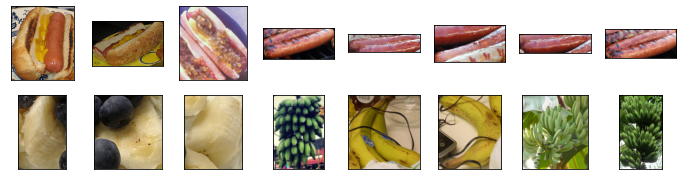

In [4]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i -1][0] for i in range(8)]
_ = d2l.show_images(hotdogs + not_hotdogs, 2, 8)
print(f'label hot_dog is {train_imgs[1][1]}, lable not hot_dog is {train_imgs[-1][1]}')
print(f'len of the train_imgs is {len(train_imgs)}')

$normalize$ 的参数是 $ImageNet$ 里面的数据进行 $Normalize$ 的时候的参数, 实测不加问题不大 (甚至还高了一点)

In [5]:
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.255])
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize
])
test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256), # short edge match 256
    torchvision.transforms.CenterCrop(224), # crop the img in the middle
    torchvision.transforms.ToTensor(),
    normalize
])

使用预训练好的权重

In [6]:
net = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)

预训练模型的输出层

In [7]:
net.fc

Linear(in_features=512, out_features=1000, bias=True)

换掉预训练的输出层

In [8]:
net.fc = nn.Linear(net.fc.in_features, 2)
_ = nn.init.xavier_uniform_(net.fc.weight)

定义一个训练函数, `param_group=True` 表示输出层的模型参数将使用 $10$ 倍的学习率

In [9]:
def train(net, train_iter, test_iter, learning_rate, batch_size=128, num_epochs=5, param_group=True):
    device = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction='none')
    if param_group:
        params_1x = [param for name, param in net.named_parameters() if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x}, {'params': net.fc.parameters(), 'lr': learning_rate * 10}], lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, device)

In [10]:
batch_size = 128
train_iter = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_augs),
    batch_size=batch_size, shuffle=True
)
test_iter = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_augs),
    batch_size=batch_size
)

定义一个获取 $net$ 的函数, 方便多次训练

In [11]:
def get_net():
    net = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
    net.fc = nn.Linear(net.fc.in_features, 2)
    nn.init.xavier_uniform_(net.fc.weight)
    return net

loss 0.298, train acc 0.897, test acc 0.936
608.8 examples/sec on [device(type='cuda', index=0)]


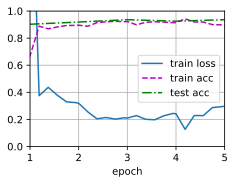

In [12]:
train(get_net(), train_iter, test_iter, 5e-5)

loss 0.085, train acc 0.968, test acc 0.945
724.0 examples/sec on [device(type='cuda', index=0)]


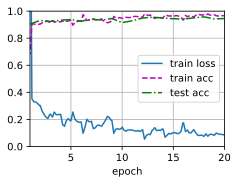

In [13]:
train(get_net(), train_iter, test_iter, 5e-5, num_epochs=20)

使用更大的学习率会怎么样

loss 0.397, train acc 0.832, test acc 0.820
717.5 examples/sec on [device(type='cuda', index=0)]


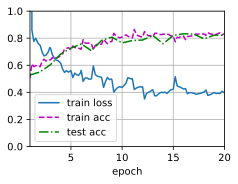

In [14]:
train(get_net(), train_iter, test_iter, 0.01, num_epochs=20, param_group=False)

loss 0.278, train acc 0.878, test acc 0.848
722.0 examples/sec on [device(type='cuda', index=0)]


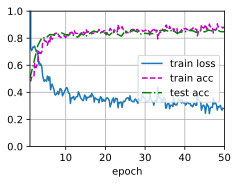

In [16]:
train(get_net(), train_iter, test_iter, 0.01, num_epochs=50, param_group=False)

可以通过设置某些层的权重不变, 这样相当于做了一个正则, 因为可变的参数更少了

loss 0.201, train acc 0.920, test acc 0.921
968.8 examples/sec on [device(type='cuda', index=0)]


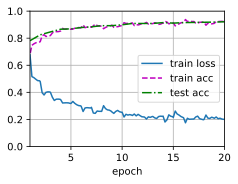

In [73]:
net = get_net()
def init(m):
    if type(m) == nn.Conv2d:
        m.weight.requires_grad = False
net.apply(init)
train(net, train_iter, test_iter, 5e-5, num_epochs=20, param_group=False)

或者这样写

loss 0.253, train acc 0.889, test acc 0.910
1657.7 examples/sec on [device(type='cuda', index=0)]


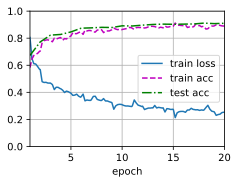

In [15]:
net = get_net()
for param in net.parameters():
    param.requires_grad = False
for param in net.fc.parameters():
    param.requires_grad = True
train(net, train_iter, test_iter, 5e-5, num_epochs=20, param_group=False)

不使用 $pre\_train$ 的参数

loss 0.271, train acc 0.897, test acc 0.866
713.0 examples/sec on [device(type='cuda', index=0)]


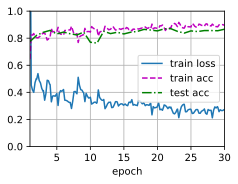

In [74]:
net = torchvision.models.resnet18()
def init(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)
net.apply(init)
train(net, train_iter, test_iter, 5e-4, num_epochs=30, param_group=False)